Sample script for MNLab2BICN.

メディアネットワーク実験IIB 項目Iで利用するサンプル．

PSK および QAM は適切に実装されていません．
`# Start of 要修正` から `# End of 要修正` の箇所を修正する必要があります．
なお，行中の一部を修正すれば良いというわけではなく，
必要に応じて行の追加が必要になります．

必要なファイルを`github`から取り出す．

In [3]:
!test -d mnlab2bicn && (cd mnlab2bicn ; git pull) || git clone https://github.com/htsutsui/mnlab2bicn/
!cp mnlab2bicn/mnlab2bicn.py .
!cp mnlab2bicn/gray.py .

Already up to date.


`mnlab2bicn`が依存する`gmpy2` (BER計算を高速化する)をインストールする．
なお，`gmpy2`が無くてもBER計算は可能(若干遅くなる)なので，エラーが生じる場合は無視すること．

In [4]:
!sudo apt-get update
!sudo apt-get install -y libgmp-dev libmpfr-dev libmpc-dev
!pip install gmpy2

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 384 kB in 1s (277 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pac

NumPy と Matplotlib を使うので`import`する．

In [5]:
import matplotlib.pyplot as plt
import numpy as np

実験で使用するあらかじめ用意されている関数を`import`する．

In [6]:
from mnlab2bicn import awgn, calc_ser, calc_ber, \
    int2gray, gray2int, scatter_plot

このscript中で利用するdebug用の変数．

In [7]:
verbose = True # True だと for loop の処理の状況(進み具合)が確認できる
verbose_awgn = False

PSKのシミュレーションを行う関数を定義する．

In [8]:
def psk_test(m_level, i_snr, i_size, plot=False, gray=False):
    """PSK test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)

    x = int2gray(src) if gray else src

    # Start of 要修正
    y = np.exp(1j*2*np.pi/m_level*x)
    # End of 要修正

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"PSK_{m_level}_{i_snr}_{i_size}")

    # Start of 要修正
    z = np.angle(y_noisy)
    z = z/(2*np.pi/m_level)
    z = z.round()
    z = np.array(z.round(), dtype='int')
    z = np.where(z<0, z+m_level, z)

    # z = np.round(y_noisy.real * (m_level - 1))
    # z = np.where(z < 0, 0, z)
    # z = np.where(z > m_level - 1, m_level - 1, z)
    # End of 要修正

    z = np.array(z, dtype='int')

    dst = gray2int(z) if gray else z

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

QAMのシミュレーションを行う関数を定義する．

In [9]:
def qam_test(m_level, i_snr, i_size, plot=False, gray=False):
    """QAM test

    Parameters
    ----------
    m_level: modulation level (integer)
    i_snr: SNR in dB
    i_size: number of samples
    plot: optional. if True, scatter plot will be generated.
    gray: optional. if True, gray code is used.

    Returns
    -------
    (SER, BER)
    """
    src = np.random.randint(m_level, size=i_size)
    k = int(np.log2(m_level))
    smax = 2 ** (k // 2) - 1

    yr = src >> (k // 2)
    yi = src & smax

    yr = int2gray(yr) if gray else yr
    yi = int2gray(yi) if gray else yi

    # Start of 要修正
    xr = 2 * yr - smax
    xi = 2 * yi - smax
    y = (xr + 1j * xi) / smax

    # y = np.exp(1j * (2 * np.pi) / (smax + 1) * yr)
    # y *= ((yi + 1) / (smax + 1))
    # End of 要修正

    y_noisy = awgn(y, i_snr, verbose_awgn)

    if plot:
        scatter_plot(y_noisy, f"QAM_{m_level}_{i_snr}_{i_size}")

    # Start of 要修正
    xr_noisy = np.round(np.real(y_noisy) * smax)
    xi_noisy = np.round(np.imag(y_noisy) * smax)

    # zr = np.round(np.angle(y_noisy)/((2 * np.pi) / (smax + 1)))
    # zr += (zr < 0)*(smax + 1)
    # zr = np.array(zr, dtype='int')

    zr = ((xr_noisy + smax) / 2).astype(int)
    zi = ((xi_noisy + smax) / 2).astype(int)



    # zi = np.round(np.abs(y_noisy) * (smax + 1))
    # zi = np.array(zi, dtype='int')
    # zi -= 1
    # End of 要修正

    zr = np.where(zr < 0, 0, zr)
    zr = np.where(zr > smax, smax, zr)
    zi = np.where(zi < 0, 0, zi)
    zi = np.where(zi > smax, smax, zi)

    zr = gray2int(zr) if gray else zr
    zi = gray2int(zi) if gray else zi

    dst = zr << (k // 2)
    dst += zi

    return (calc_ser(src, dst), calc_ber(src, dst, m_level))

グラフのフォントサイズを調整する．

In [10]:
plt.rcParams.update({'font.size': 16})

PSKのシミュレーションを行う．図は`PSK_4_30_100.png`および`PSK_4_30_100.pdf`に保存される．以下同様．

返り値は(SER, BER)．多値数，SNR，およびサンプル数を様々に変更してシミュレーションする(課題1，2)．

(0.0, 0.0)

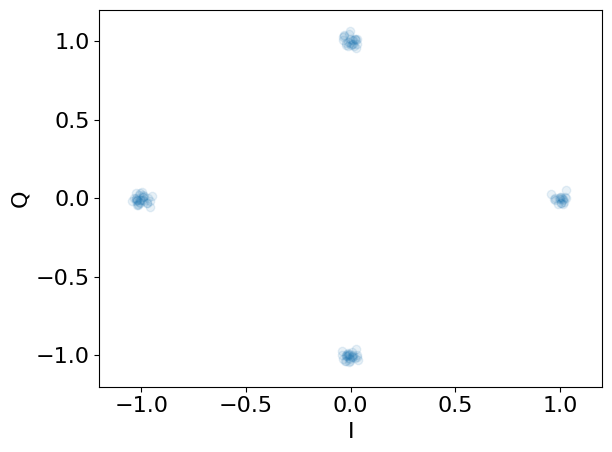

In [11]:
psk_test(4, 30, 100, plot=True)

(0.0, 0.0)

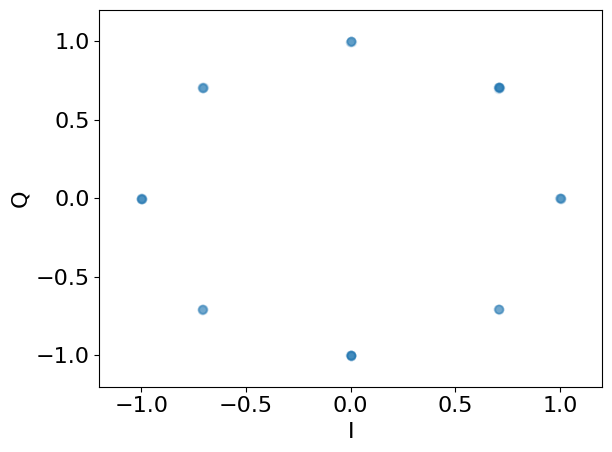

In [12]:
psk_test(8, 50, 100, plot=True)

(0.0, 0.0)

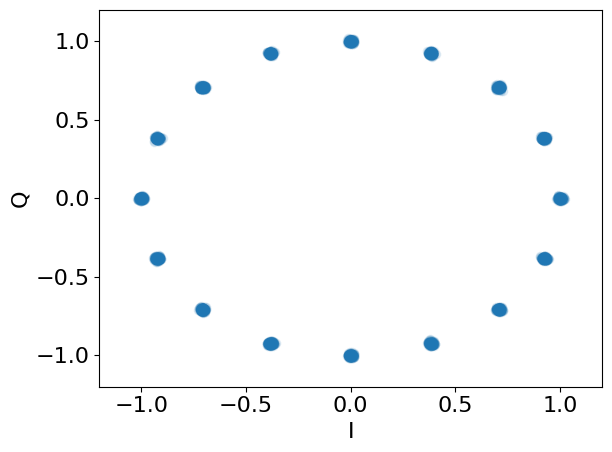

In [13]:
psk_test(16, 40, 4000, plot=True)

QAMのシミュレーションを行う．

返り値は(SER, BER)．多値数，SNR，およびサンプル数を様々に変更してシミュレーションする(課題1，2)．

(0.0, 0.0)

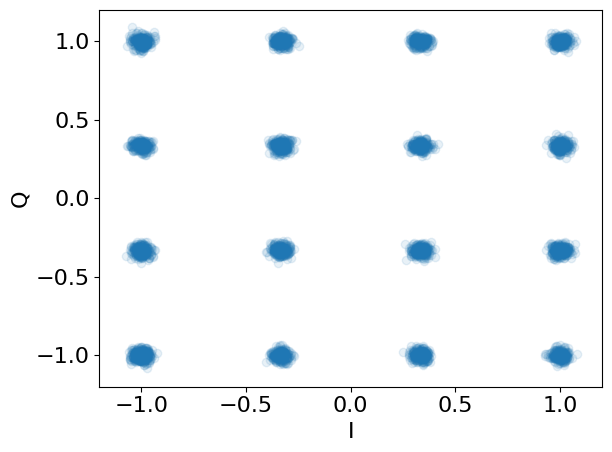

In [60]:
qam_test(16, 30, 4000, plot=True)

(0.0005, 0.00020833333333333335)

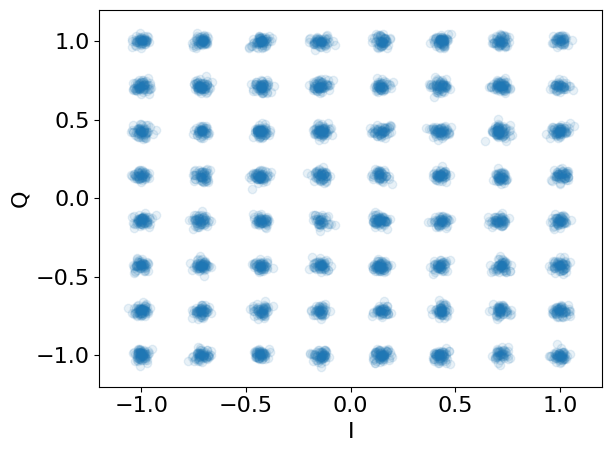

In [59]:
qam_test(64, 30, 4000, plot=True)

グラフのフォントサイズを調整する．

In [16]:
psk_test(4, 0, 20000)

(0.29595, 0.21475)

In [17]:
psk_test(4, 4, 20000)

(0.1143, 0.084975)

In [18]:
psk_test(4, 8, 20000)

(0.01215, 0.009075)

In [19]:
psk_test(4, 12, 20000)

(0.0001, 5e-05)

In [20]:
psk_test(8, 0, 20000)

(0.57845, 0.3294166666666667)

In [21]:
psk_test(8, 4, 20000)

(0.3893, 0.22606666666666667)

In [22]:
psk_test(8, 8, 20000)

(0.17105, 0.1005)

In [23]:
psk_test(8, 12, 20000)

(0.0323, 0.01885)

In [24]:
qam_test(16, 0, 20000)

(0.75, 0.3123125)

In [25]:
qam_test(16, 4, 29000)

(0.6108275862068966, 0.24493103448275863)

In [26]:
qam_test(16, 8, 20000)

(0.4369, 0.1664)

In [27]:
qam_test(16, 12, 20000)

(0.2677, 0.0963125)

In [28]:
qam_test(64, 0, 20000)

(0.9231, 0.3652666666666667)

In [29]:
qam_test(64, 4, 20000)

(0.86755, 0.3208916666666667)

In [30]:
qam_test(64, 8, 20000)

(0.7685, 0.2645166666666667)

In [31]:
qam_test(16, 12, 20000)

(0.2662, 0.0952125)

(5e-05, 3e-05)

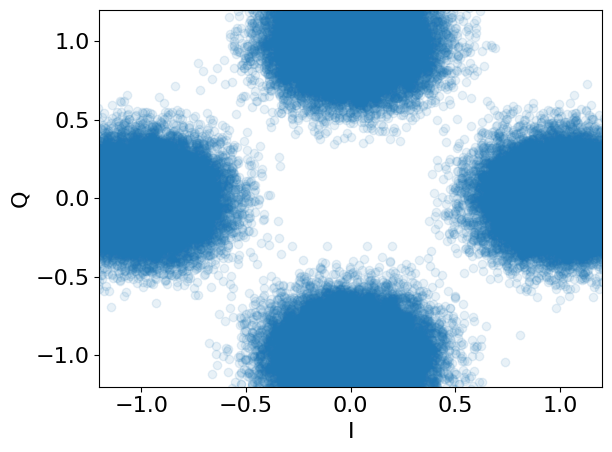

In [103]:
#実験2 (2)
psk_test(4, 12, 100000, plot = True)

In [14]:
plt.rcParams.update({'font.size': 12})

PSK/QAM Comparison

課題3．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.94, 0.42305]
[2, 64, 0.927, 0.3992833333333333]
[4, 64, 0.9168, 0.3806333333333333]
[6, 64, 0.8834, 0.34973333333333334]
[8, 64, 0.8643, 0.33063333333333333]
[10, 64, 0.8309, 0.30356666666666665]
[12, 64, 0.7818, 0.27485]
[14, 64, 0.7264, 0.24735]
[16, 64, 0.6577, 0.21851666666666666]
[18, 64, 0.5835, 0.19231666666666666]
[20, 64, 0.4892, 0.1622]
[22, 64, 0.3812, 0.12483333333333334]
[24, 64, 0.2726, 0.09003333333333334]
[26, 64, 0.1622, 0.05163333333333334]
[28, 64, 0.0816, 0.028166666666666666]
[30, 64, 0.0284, 0.009483333333333333]
[32, 64, 0.0067, 0.0021666666666666666]
[34, 64, 0.0007, 0.00013333333333333334]
[36, 64, 0.0, 0.0]
[0, 64, 0.9255, 0.36728333333333335]
[2, 64, 0.9021, 0.3452]
[4, 64, 0.8745, 0.3260166666666667]
[6, 64, 0.8302, 0.29573333333333335]
[8, 64, 0.7681, 0.2633]
[10, 64, 0.7029, 0.23575]
[12, 64, 0.6059, 0.19365]
[14, 64, 0.5088, 0.1566]
[16, 64, 0.4052, 0.1203]
[18, 64, 0.3143, 0.09075]
[20, 64, 0.2248, 0.06275]
[22, 64, 0.1447, 0.03935]
[24, 64, 0.

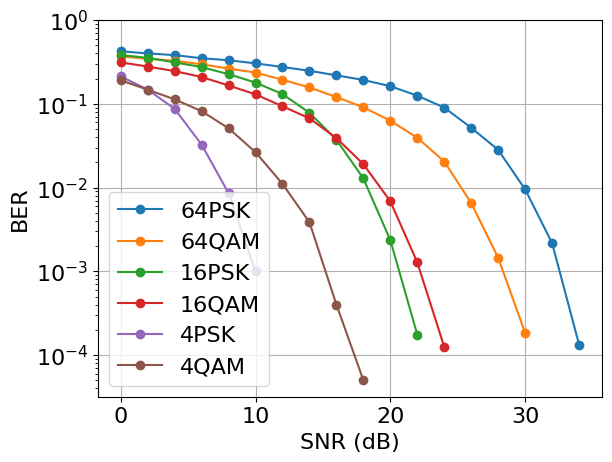

In [104]:
size = 10000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_QAM.png")
plt.savefig("PSK_QAM.pdf")

PSK Gray Code Comparison

課題4．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.9425, 0.4217666666666667]
[2, 64, 0.9301, 0.39903333333333335]
[4, 64, 0.9161, 0.376]
[6, 64, 0.8892, 0.3523833333333333]
[8, 64, 0.8595, 0.32695]
[10, 64, 0.8252, 0.30523333333333336]
[12, 64, 0.7844, 0.2780166666666667]
[14, 64, 0.7358, 0.25271666666666665]
[16, 64, 0.6569, 0.21746666666666667]
[18, 64, 0.5829, 0.19061666666666666]
[20, 64, 0.4838, 0.15795]
[22, 64, 0.3768, 0.12485]
[24, 64, 0.2746, 0.08945]
[26, 64, 0.1663, 0.05315]
[28, 64, 0.0825, 0.028066666666666667]
[30, 64, 0.0279, 0.008866666666666667]
[32, 64, 0.0047, 0.0015333333333333334]
[34, 64, 0.0005, 0.00016666666666666666]
[36, 64, 0.0, 0.0]
[0, 64, 0.9444, 0.38258333333333333]
[2, 64, 0.9302, 0.3582166666666667]
[4, 64, 0.9111, 0.33065]
[6, 64, 0.8869, 0.3047666666666667]
[8, 64, 0.8639, 0.2757]
[10, 64, 0.823, 0.24735]
[12, 64, 0.7796, 0.2206]
[14, 64, 0.7288, 0.19518333333333332]
[16, 64, 0.6565, 0.16411666666666666]
[18, 64, 0.5776, 0.1363]
[20, 64, 0.4892, 0.11181666666666666]
[22, 64, 0.3801, 0.084]
[

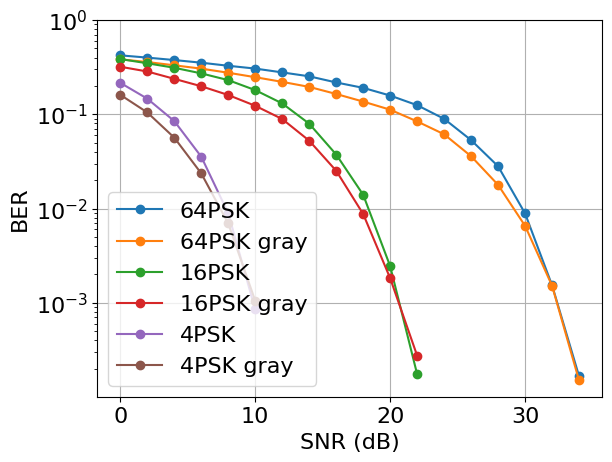

In [105]:
size = 10000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = psk_test(m, snr, size, gray=True)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}PSK gray")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("PSK_gray.png")
plt.savefig("PSK_gray.pdf")

QAM Gray Code Comparison

課題4．サンプル数(`size`)は適宜調整すること．

[0, 64, 0.9274, 0.36656666666666665]
[2, 64, 0.8986, 0.34491666666666665]
[4, 64, 0.8762, 0.32193333333333335]
[6, 64, 0.8279, 0.2942166666666667]
[8, 64, 0.7683, 0.26485]
[10, 64, 0.6965, 0.23296666666666666]
[12, 64, 0.6096, 0.19558333333333333]
[14, 64, 0.5176, 0.15973333333333334]
[16, 64, 0.4069, 0.11935]
[18, 64, 0.313, 0.09075]
[20, 64, 0.2317, 0.06486666666666667]
[22, 64, 0.1394, 0.03725]
[24, 64, 0.0678, 0.01765]
[26, 64, 0.0256, 0.0064333333333333334]
[28, 64, 0.0055, 0.0014666666666666667]
[30, 64, 0.0008, 0.00025]
[32, 64, 0.0, 0.0]
[0, 64, 0.9249, 0.3563]
[2, 64, 0.9007, 0.32405]
[4, 64, 0.8691, 0.28531666666666666]
[6, 64, 0.8259, 0.25065]
[8, 64, 0.7784, 0.21288333333333334]
[10, 64, 0.7013, 0.18026666666666666]
[12, 64, 0.6047, 0.14368333333333333]
[14, 64, 0.506, 0.11295]
[16, 64, 0.4057, 0.08628333333333334]
[18, 64, 0.3101, 0.0648]
[20, 64, 0.2245, 0.04546666666666667]
[22, 64, 0.1348, 0.0262]
[24, 64, 0.0703, 0.013533333333333333]
[26, 64, 0.0259, 0.005066666666666

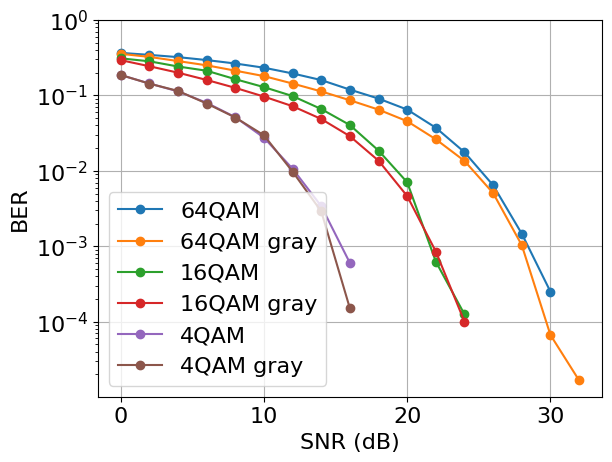

In [106]:
size = 10000
for m in [64, 16, 4]:
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM")
    snrs = []
    bers = []
    for snr in range(0, 55, 2):
        ser, ber = qam_test(m, snr, size, gray=True)
        if verbose:
            print([snr, m, ser, ber])
        if ber < 1e-6:
            break
        snrs.append(snr)
        bers.append(ber)
    plt.semilogy(snrs, bers, '-o', label=f"{m}QAM gray")

plt.grid()
plt.xlabel("SNR (dB)")
plt.ylabel("BER")
plt.legend()
plt.tight_layout()
plt.ylim(top=1)
plt.savefig("QAM_gray.png")
plt.savefig("QAM_gray.pdf")